# Assignment 3 - Statiscal Modelling
# Muneel Haider
# i210640
# Section A

### Assignment Instructions

In this assignment, you will build and evaluate **five Bayesian logistic regression models using PyMC**. Your goal is to classify students as **"Excellent"** or **"Bad"** based on different input features from the dataset.

#### Dataset Description

The dataset includes the following columns:

- `study_hours`
- `sleep_hours`
- `social_time`
- `quiz_score`  
- **Target column**: `student_type` (values: Excellent or Bad)

#### Modeling Task

You will create five separate models. Each model will perform the same classification task but will use different input features:

- **Model 0**: Use only `study_hours` to predict `student_type`
- **Model 1**: Use only `social_time` to predict `student_type`
- **Model 2**: Use only `quiz_score` to predict `student_type`
- **Model 3**: Use both `study_hours` and `social_time`
- **Model 4**: Use both `study_hours` and `quiz_score`

This setup will help you explore how model performance changes when using different predictors, and when moving from simple to multiple logistic regression.

#### Evaluation

After building the models, compare them using **Bayesian information criteria**:

- **LOO (Leave-One-Out Cross-Validation)**
- **WAIC (Widely Applicable Information Criterion)**

Use the `arviz.compare()` function to perform the comparison. This will help you determine which model offers the best trade-off between prediction accuracy and model complexity.

#### Implementation Guidance

- The notebook contains **`TODO:` comments** throughout the code cells.
- Follow these `TODO:` markers and use the **expected output and structure** as a guide for your implementation.
- Stick closely to the template provided to ensure consistent results across all models.

#### Learning Objectives

By the end of this assignment, you should be able to:

- Build and interpret Bayesian logistic regression models using PyMC
- Understand how different input features affect classification outcomes
- Apply model comparison techniques using LOO and WAIC


In [1]:
!pip install --upgrade arviz

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [3]:
df1 = pd.read_csv('Syn_student.csv')
df1.head()

,study_hours,sleep_hours,social_time,quiz_score,student_type
0,8.248357,7.162042,1.292315,9.125246,excellent
1,7.930868,6.807459,1.789677,9.173224,excellent
2,8.323844,6.661539,1.828643,8.659988,excellent
3,8.761515,7.305838,1.598861,9.116127,excellent
4,7.882923,7.515500,1.919357,9.146536,excellent


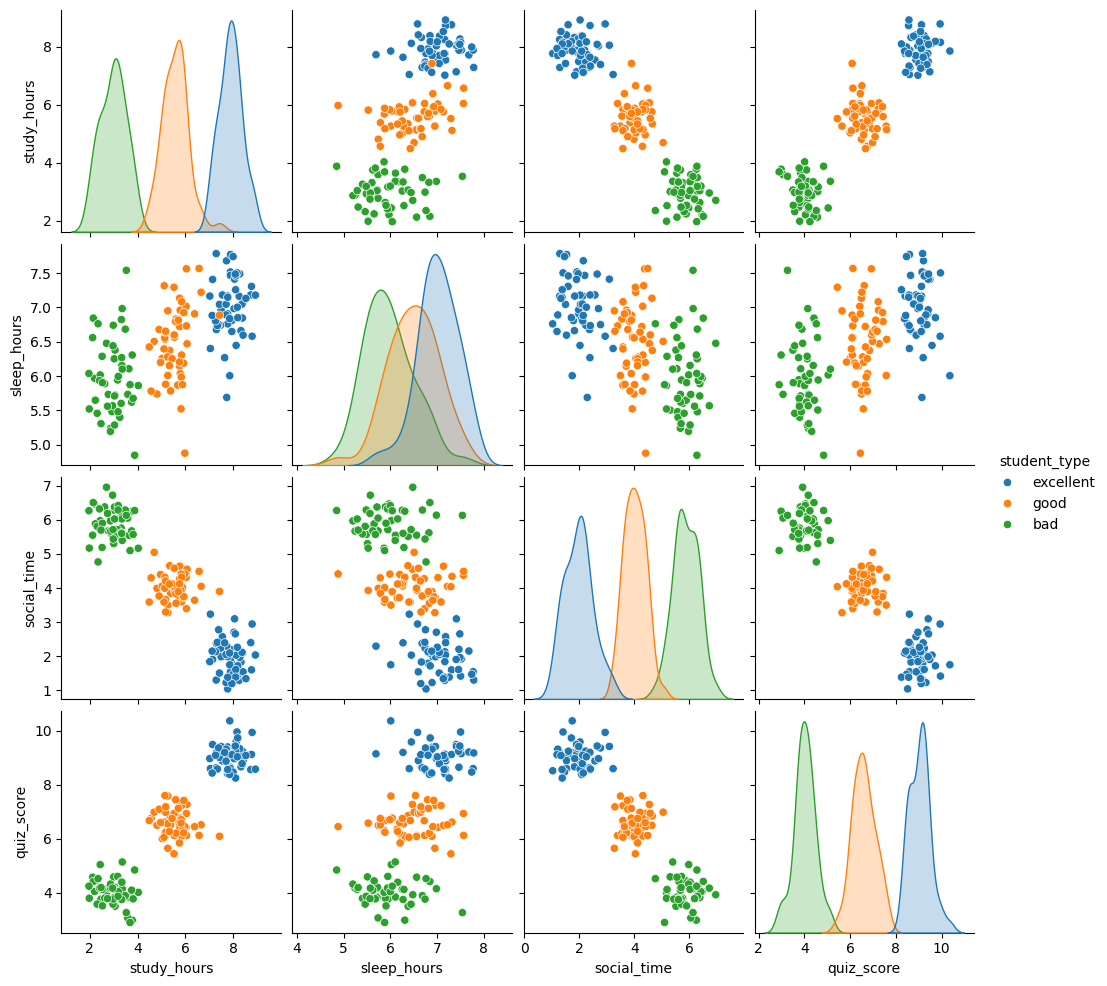

In [4]:
sns.pairplot(df1, hue='student_type', diag_kind='kde')
plt.savefig('B11197_04_03.png', bbox_inches='tight');

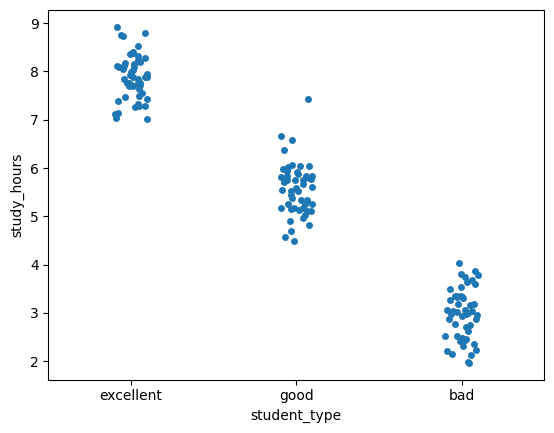

In [5]:
sns.stripplot(x="student_type", y="study_hours", data=df1, jitter=True)
plt.savefig('B11197_04_02.png', dpi=300);

## Model 0: study_hours Only

In [6]:
df = df1.copy()

y_0 = pd.Categorical(df['student_type']).codes

x_n = 'study_hours'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [7]:
with pm.Model() as model_0:
    α = pm.Normal("α", mu=0, sigma=1, shape=3)
    β = pm.Normal("β", mu=0, sigma=1, shape=3)

    logits = α + β * x_c[:, None]

    yl = pm.Categorical("yl", logit_p=logits, observed=y_0)

    trace_0 = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Output()

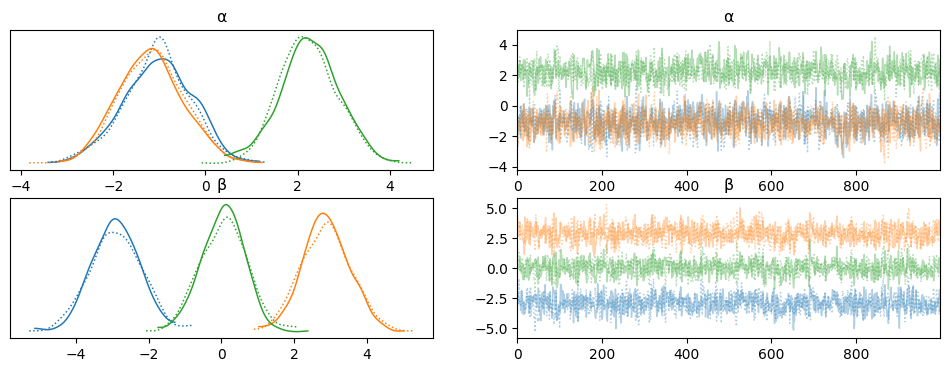

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-1.038,0.740,-2.559,0.333,0.026,0.017,847.0,896.0,1.0
α[1],-1.175,0.710,-2.472,0.281,0.020,0.016,1255.0,1235.0,1.0
α[2],2.246,0.640,1.020,3.512,0.021,0.015,969.0,1191.0,1.0
β[0],-2.911,0.684,-4.183,-1.560,0.021,0.018,1067.0,876.0,1.0
β[1],2.884,0.663,1.514,4.079,0.021,0.015,1011.0,863.0,1.0
β[2],0.053,0.622,-1.214,1.185,0.020,0.016,944.0,929.0,1.0


In [8]:
az.plot_trace(trace_0)
plt.show()

az.summary(trace_0, hdi_prob=0.95)

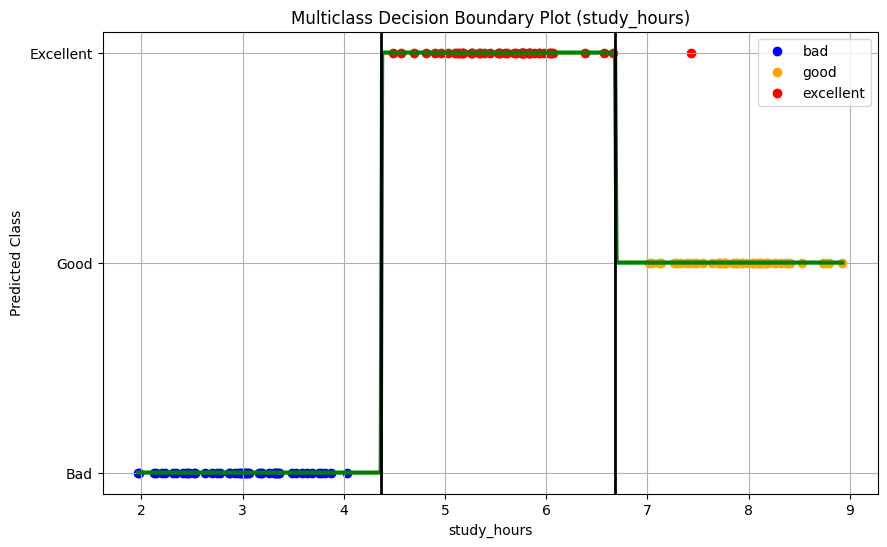

In [9]:
x_plot = np.linspace(x_0.min(), x_0.max(), 500)
x_plot_c = x_plot - x_0.mean()

α_mean = trace_0.posterior['α'].mean(dim=("chain", "draw")).values
β_mean = trace_0.posterior['β'].mean(dim=("chain", "draw")).values

logits = α_mean + β_mean * x_plot_c[:, None]

def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1, keepdims=True)

probs = softmax(logits)
predicted_class = np.argmax(probs, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, predicted_class, color='green', linewidth=3)

boundaries = np.where(np.diff(predicted_class) != 0)[0]
for b in boundaries:
    plt.axvline(x_plot[b], color='black', linewidth=2)

color_map = {0: 'blue', 1: 'orange', 2: 'red'}
classes = {0: 'bad', 1: 'good', 2: 'excellent'}
for class_index in np.unique(y_0):
    plt.scatter(x_0[y_0 == class_index], [class_index] * sum(y_0 == class_index),
                color=color_map[class_index], label=f'{classes[class_index]}')

plt.yticks([0, 1, 2], ['Bad', 'Good', 'Excellent'])
plt.xlabel("study_hours")
plt.ylabel("Predicted Class")
plt.title("Multiclass Decision Boundary Plot (study_hours)")
plt.grid(True)
plt.legend()
plt.show()

# ---------------------------------------------------------------------------------------------

## Model 1: social_time Only

In [10]:
df = df1.copy()

y_1 = pd.Categorical(df['student_type']).codes  # 0 = bad, 1 = good, 2 = excellent

x1_n = 'social_time'
x1_0 = df[x1_n].values
x1_c = x1_0 - x1_0.mean()  # Center the input

In [11]:
with pm.Model() as model_1:
    α = pm.Normal("α", mu=0, sigma=1, shape=3)
    β = pm.Normal("β", mu=0, sigma=1, shape=3)

    logits = α + β * x1_c[:, None]

    yl = pm.Categorical("yl", logit_p=logits, observed=y_1)

    trace_1 = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Output()

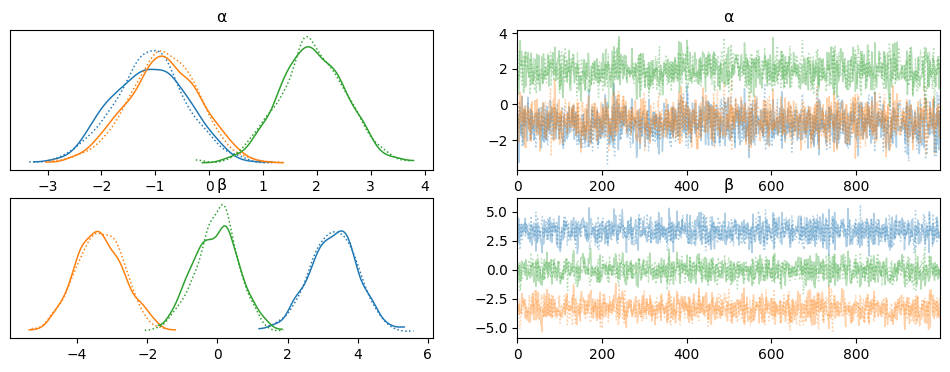

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-1.104,0.696,-2.460,0.201,0.020,0.014,1153.0,1309.0,1.0
α[1],-0.855,0.674,-2.189,0.459,0.020,0.015,1129.0,1265.0,1.0
α[2],1.913,0.623,0.702,3.118,0.020,0.014,968.0,1146.0,1.0
β[0],3.309,0.687,2.003,4.666,0.018,0.014,1418.0,1159.0,1.0
β[1],-3.355,0.680,-4.762,-2.131,0.020,0.014,1191.0,1163.0,1.0
β[2],-0.034,0.624,-1.306,1.111,0.019,0.014,1116.0,1146.0,1.0


In [12]:
az.plot_trace(trace_1)
plt.show()

az.summary(trace_1, hdi_prob=0.95)

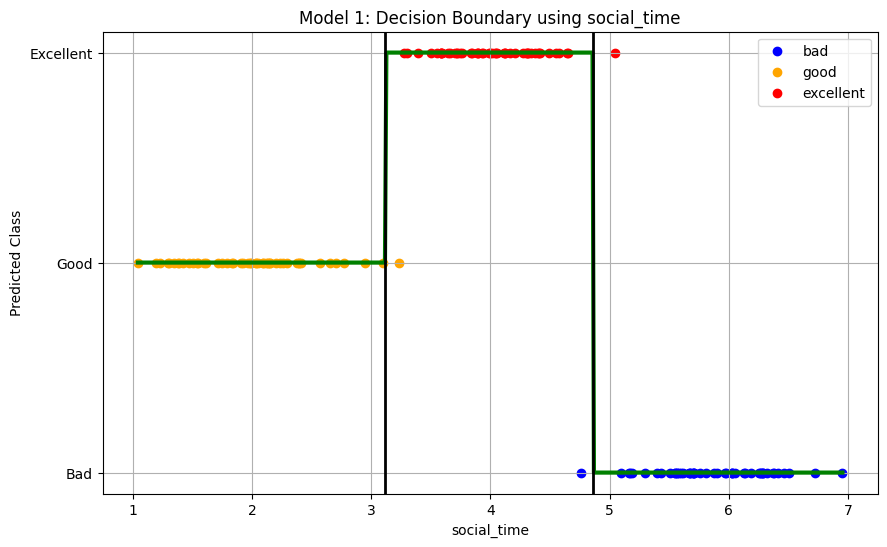

In [13]:
x1_plot = np.linspace(x1_0.min(), x1_0.max(), 500)
x1_plot_c = x1_plot - x1_0.mean()

α_mean = trace_1.posterior['α'].mean(dim=("chain", "draw")).values
β_mean = trace_1.posterior['β'].mean(dim=("chain", "draw")).values

logits = α_mean + β_mean * x1_plot_c[:, None]

def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1, keepdims=True)

probs = softmax(logits)
predicted_class = np.argmax(probs, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(x1_plot, predicted_class, color='green', linewidth=3)

boundaries = np.where(np.diff(predicted_class) != 0)[0]
for b in boundaries:
    plt.axvline(x1_plot[b], color='black', linewidth=2)

color_map = {0: 'blue', 1: 'orange', 2: 'red'}
classes = {0: 'bad', 1: 'good', 2: 'excellent'}
for class_index in np.unique(y_1):
    plt.scatter(x1_0[y_1 == class_index], [class_index] * sum(y_1 == class_index),
                color=color_map[class_index], label=f'{classes[class_index]}')

plt.yticks([0, 1, 2], ['Bad', 'Good', 'Excellent'])
plt.xlabel("social_time")
plt.ylabel("Predicted Class")
plt.title("Model 1: Decision Boundary using social_time")
plt.grid(True)
plt.legend()
plt.show()


# ----------------------------------------

# Model 2: quiz_score Only

In [15]:
df = df1.copy()

y_2 = pd.Categorical(df['student_type']).codes  # 0 = bad, 1 = good, 2 = excellent

x2_n = 'quiz_score'
x2_0 = df[x2_n].values
x2_c = x2_0 - x2_0.mean()

In [16]:
with pm.Model() as model_2:
    α = pm.Normal("α", mu=0, sigma=1, shape=3)
    β = pm.Normal("β", mu=0, sigma=1, shape=3)

    logits = α + β * x2_c[:, None]

    yl = pm.Categorical("yl", logit_p=logits, observed=y_2)

    trace_2 = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Output()

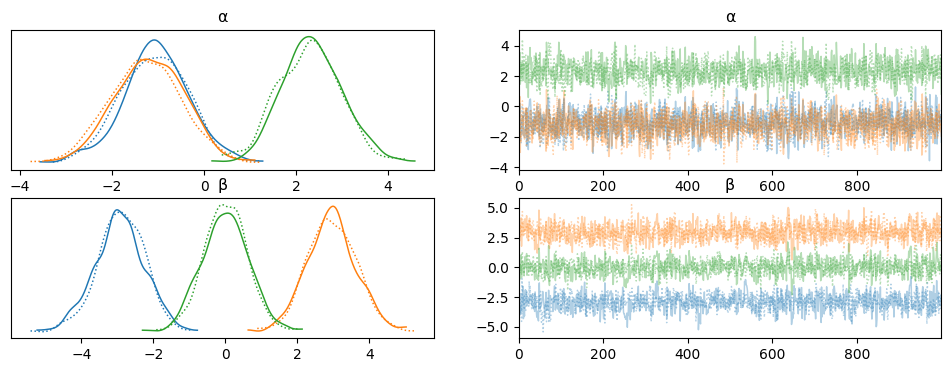

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-1.065,0.735,-2.634,0.346,0.021,0.016,1175.0,1141.0,1.0
α[1],-1.234,0.774,-2.790,0.184,0.023,0.017,1158.0,1196.0,1.0
α[2],2.318,0.686,1.000,3.681,0.022,0.017,951.0,1065.0,1.0
β[0],-2.918,0.672,-4.346,-1.668,0.024,0.017,774.0,834.0,1.0
β[1],2.954,0.680,1.694,4.350,0.021,0.017,1022.0,1170.0,1.0
β[2],0.005,0.627,-1.159,1.285,0.021,0.018,924.0,1013.0,1.0


In [17]:
az.plot_trace(trace_2)
plt.show()

az.summary(trace_2, hdi_prob=0.95)

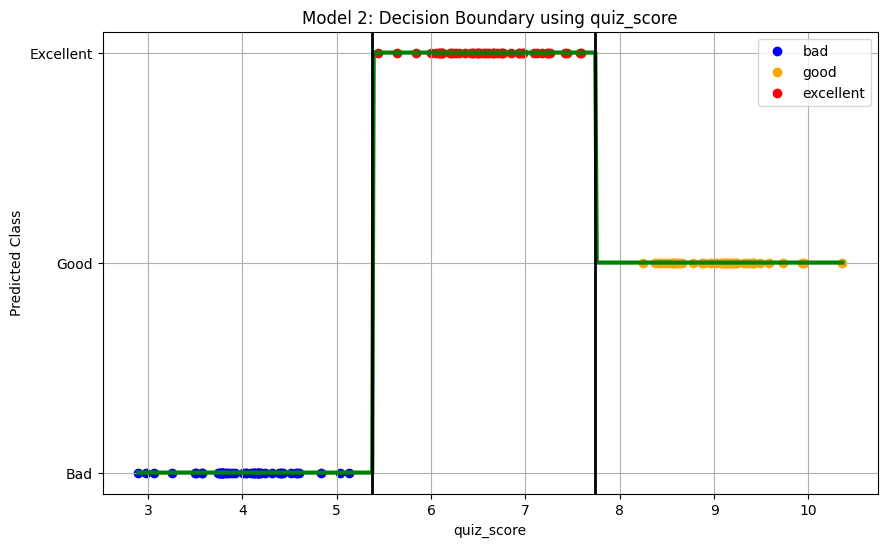

In [18]:
x2_plot = np.linspace(x2_0.min(), x2_0.max(), 500)
x2_plot_c = x2_plot - x2_0.mean()

α_mean = trace_2.posterior['α'].mean(dim=("chain", "draw")).values
β_mean = trace_2.posterior['β'].mean(dim=("chain", "draw")).values

logits = α_mean + β_mean * x2_plot_c[:, None]

def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1, keepdims=True)

probs = softmax(logits)
predicted_class = np.argmax(probs, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(x2_plot, predicted_class, color='green', linewidth=3)

boundaries = np.where(np.diff(predicted_class) != 0)[0]
for b in boundaries:
    plt.axvline(x2_plot[b], color='black', linewidth=2)

color_map = {0: 'blue', 1: 'orange', 2: 'red'}
classes = {0: 'bad', 1: 'good', 2: 'excellent'}
for class_index in np.unique(y_2):
    plt.scatter(x2_0[y_2 == class_index], [class_index] * sum(y_2 == class_index),
                color=color_map[class_index], label=f'{classes[class_index]}')

plt.yticks([0, 1, 2], ['Bad', 'Good', 'Excellent'])
plt.xlabel("quiz_score")
plt.ylabel("Predicted Class")
plt.title("Model 2: Decision Boundary using quiz_score")
plt.grid(True)
plt.legend()
plt.show()


# ------------------------------------------------------------------------------------

## Model 3: study_hours and social_time


In [19]:
# Keep all 3 student types
df = df1.copy()

y_3 = pd.Categorical(df['student_type']).codes  # 0 = bad, 1 = good, 2 = excellent

x3_1 = df['study_hours'].values
x3_2 = df['quiz_score'].values

x3_1_c = x3_1 - x3_1.mean()
x3_2_c = x3_2 - x3_2.mean()

In [20]:
with pm.Model() as model_3:
    α = pm.Normal("α", mu=0, sigma=1, shape=3)
    β1 = pm.Normal("β1", mu=0, sigma=1, shape=3)  # for study_hours
    β2 = pm.Normal("β2", mu=0, sigma=1, shape=3)  # for quiz_score

    logits = α + β1 * x3_1_c[:, None] + β2 * x3_2_c[:, None]

    yl = pm.Categorical("yl", logit_p=logits, observed=y_3)

    trace_3 = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Output()

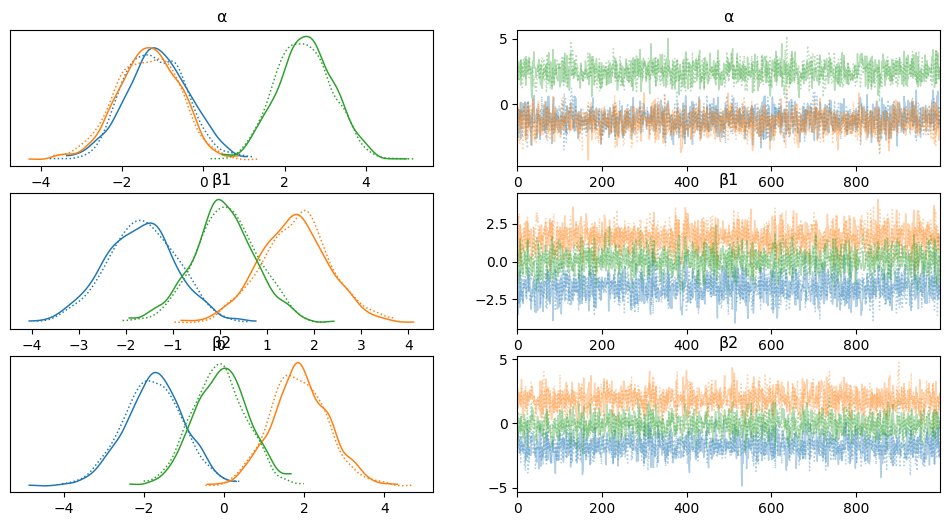

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-1.155,0.761,-2.709,0.210,0.022,0.016,1249.0,1096.0,1.0
α[1],-1.371,0.767,-2.855,0.127,0.021,0.017,1321.0,1195.0,1.0
α[2],2.494,0.697,1.163,3.844,0.020,0.015,1169.0,1351.0,1.0
β1[0],-1.679,0.751,-3.187,-0.248,0.020,0.014,1411.0,1336.0,1.0
β1[1],1.586,0.736,0.030,2.915,0.019,0.015,1431.0,1407.0,1.0
β1[2],0.101,0.673,-1.120,1.528,0.019,0.015,1227.0,1167.0,1.0
β2[0],-1.756,0.745,-3.150,-0.260,0.019,0.016,1483.0,1467.0,1.0
β2[1],1.885,0.722,0.476,3.299,0.020,0.016,1256.0,1374.0,1.0
β2[2],-0.093,0.673,-1.404,1.166,0.019,0.014,1262.0,1389.0,1.0


In [21]:
az.plot_trace(trace_3)
plt.show()

az.summary(trace_3, hdi_prob=0.95)

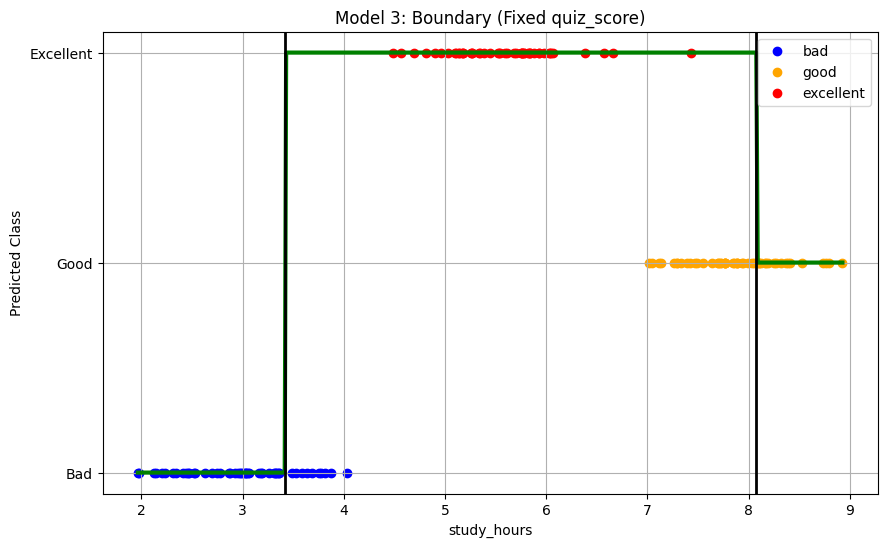

In [22]:
quiz_fixed = x3_2.mean()

x_plot = np.linspace(x3_1.min(), x3_1.max(), 500)
x_plot_c = x_plot - x3_1.mean()
quiz_fixed_c = quiz_fixed - x3_2.mean()

α_mean = trace_3.posterior['α'].mean(dim=("chain", "draw")).values
β1_mean = trace_3.posterior['β1'].mean(dim=("chain", "draw")).values
β2_mean = trace_3.posterior['β2'].mean(dim=("chain", "draw")).values

logits = α_mean + β1_mean * x_plot_c[:, None] + β2_mean * quiz_fixed_c
def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1, keepdims=True)

probs = softmax(logits)
predicted_class = np.argmax(probs, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, predicted_class, color='green', linewidth=3)

boundaries = np.where(np.diff(predicted_class) != 0)[0]
for b in boundaries:
    plt.axvline(x_plot[b], color='black', linewidth=2)

color_map = {0: 'blue', 1: 'orange', 2: 'red'}
classes = {0: 'bad', 1: 'good', 2: 'excellent'}
for class_index in np.unique(y_3):
    plt.scatter(x3_1[y_3 == class_index], [class_index] * sum(y_3 == class_index),
                color=color_map[class_index], label=f'{classes[class_index]}')

plt.yticks([0, 1, 2], ['Bad', 'Good', 'Excellent'])
plt.xlabel("study_hours")
plt.ylabel("Predicted Class")
plt.title("Model 3: Boundary (Fixed quiz_score)")
plt.legend()
plt.grid(True)
plt.show()

## Model 4: study_hours and quiz_score

In [23]:
df = df1.copy()

y_4 = pd.Categorical(df['student_type']).codes

x4_1 = df['study_hours'].values
x4_2 = df['social_time'].values

x4_1_c = x4_1 - x4_1.mean()
x4_2_c = x4_2 - x4_2.mean()

In [24]:
with pm.Model() as model_4:
    α = pm.Normal("α", mu=0, sigma=1, shape=3)
    β1 = pm.Normal("β1", mu=0, sigma=1, shape=3)  # study_hours
    β2 = pm.Normal("β2", mu=0, sigma=1, shape=3)  # social_time

    logits = α + β1 * x4_1_c[:, None] + β2 * x4_2_c[:, None]

    yl = pm.Categorical("yl", logit_p=logits, observed=y_4)

    trace_4 = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Output()

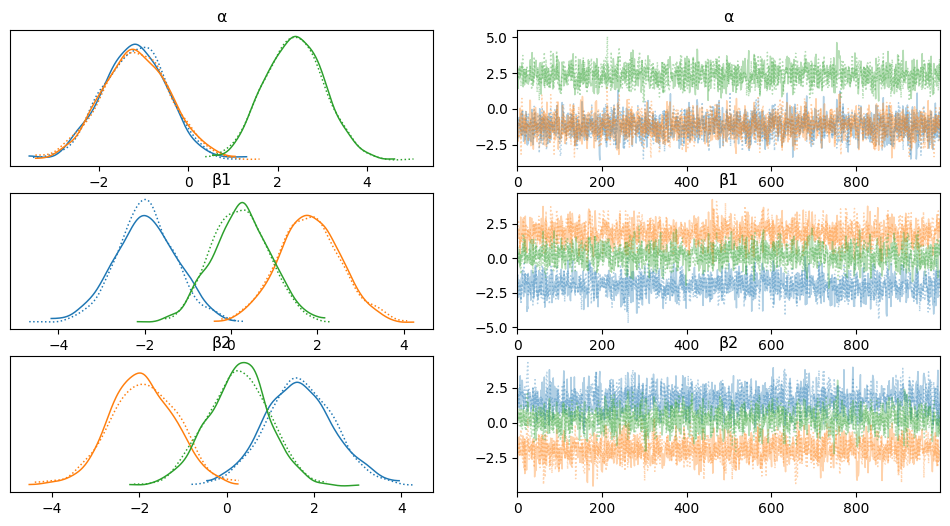

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-1.200,0.726,-2.579,0.207,0.018,0.015,1626.0,1617.0,1.0
α[1],-1.174,0.761,-2.748,0.228,0.018,0.016,1692.0,1400.0,1.0
α[2],2.370,0.659,1.115,3.640,0.018,0.012,1407.0,1271.0,1.0
β1[0],-1.972,0.714,-3.426,-0.558,0.019,0.016,1390.0,1210.0,1.0
β1[1],1.824,0.719,0.487,3.373,0.019,0.014,1451.0,1532.0,1.0
β1[2],0.226,0.667,-1.016,1.539,0.019,0.013,1277.0,1300.0,1.0
β2[0],1.672,0.794,0.177,3.273,0.022,0.016,1259.0,1284.0,1.0
β2[1],-1.925,0.766,-3.416,-0.443,0.022,0.018,1237.0,1180.0,1.0
β2[2],0.259,0.712,-1.149,1.604,0.021,0.015,1206.0,1363.0,1.0


In [25]:
az.plot_trace(trace_4)
plt.show()

az.summary(trace_4, hdi_prob=0.95)

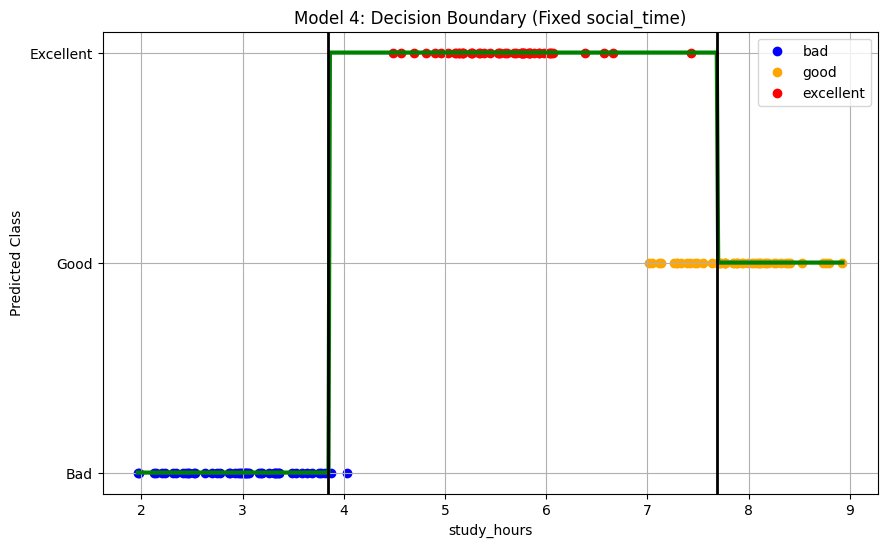

In [26]:
fixed_social = x4_2.mean()

x_plot = np.linspace(x4_1.min(), x4_1.max(), 500)
x_plot_c = x_plot - x4_1.mean()
fixed_social_c = fixed_social - x4_2.mean()

α_mean = trace_4.posterior['α'].mean(dim=("chain", "draw")).values
β1_mean = trace_4.posterior['β1'].mean(dim=("chain", "draw")).values
β2_mean = trace_4.posterior['β2'].mean(dim=("chain", "draw")).values

logits = α_mean + β1_mean * x_plot_c[:, None] + β2_mean * fixed_social_c
def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1, keepdims=True)

probs = softmax(logits)
predicted_class = np.argmax(probs, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, predicted_class, color='green', linewidth=3)

boundaries = np.where(np.diff(predicted_class) != 0)[0]
for b in boundaries:
    plt.axvline(x_plot[b], color='black', linewidth=2)

color_map = {0: 'blue', 1: 'orange', 2: 'red'}
classes = {0: 'bad', 1: 'good', 2: 'excellent'}
for class_index in np.unique(y_4):
    plt.scatter(x4_1[y_4 == class_index], [class_index] * sum(y_4 == class_index),
                color=color_map[class_index], label=f'{classes[class_index]}')

plt.yticks([0, 1, 2], ['Bad', 'Good', 'Excellent'])
plt.xlabel("study_hours")
plt.ylabel("Predicted Class")
plt.title("Model 4: Decision Boundary (Fixed social_time)")
plt.legend()
plt.grid(True)
plt.show()

## Comparison via Information criteria
- LOO or
- WAIC

In [ ]:
model_dict = {
    "model_0": trace_0,
    "model_1": trace_1,
    "model_2": trace_2,
    "model_3": trace_3,
    "model_4": trace_4
}

# Use WAIC instead of LOO
comparison_df = az.compare(model_dict, method="BB-pseudo-BMA", ic="waic", scale="deviance")
comparison_df

C:\Users\Almas\anaconda3\envs\python3\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_0,0,0.161298,0.001162,0.000000,0.238131,0.018961,0.000000,False,deviance
model_2,1,0.207122,0.001978,0.045823,0.232573,0.022638,0.029789,False,deviance
model_1,2,0.266323,0.003710,0.105025,0.225965,0.067082,0.066237,True,deviance
model_3,3,0.838994,0.047996,0.677695,0.170991,0.183690,0.172610,False,deviance
model_4,4,1.343143,0.037953,1.181845,0.132340,0.152657,0.143173,False,deviance


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

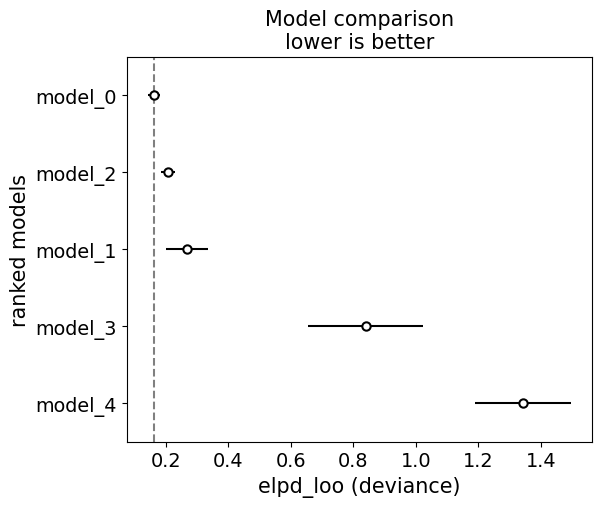

In [ ]:
fixed_social = x4_2.mean()

x_plot = np.linspace(x4_1.min(), x4_1.max(), 500)
x_plot_c = x_plot - x4_1.mean()
fixed_social_c = fixed_social - x4_2.mean()

α_mean = trace_4.posterior['α'].mean(dim=("chain", "draw")).values
β1_mean = trace_4.posterior['β1'].mean(dim=("chain", "draw")).values
β2_mean = trace_4.posterior['β2'].mean(dim=("chain", "draw")).values

logits = α_mean + β1_mean * x_plot_c[:, None] + β2_mean * fixed_social_c
def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1, keepdims=True)

probs = softmax(logits)
predicted_class = np.argmax(probs, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, predicted_class, color='green', linewidth=3)

boundaries = np.where(np.diff(predicted_class) != 0)[0]
for b in boundaries:
    plt.axvline(x_plot[b], color='black', linewidth=2)

color_map = {0: 'blue', 1: 'orange', 2: 'red'}
classes = {0: 'bad', 1: 'good', 2: 'excellent'}
for class_index in np.unique(y_4):
    plt.scatter(x4_1[y_4 == class_index], [class_index] * sum(y_4 == class_index),
                color=color_map[class_index], label=f'{classes[class_index]}')

plt.yticks([0, 1, 2], ['Bad', 'Good', 'Excellent'])
plt.xlabel("study_hours")
plt.ylabel("Predicted Class")
plt.title("Model 4: Decision Boundary (Fixed social_time)")
plt.legend()
plt.grid(True)
plt.show()

### Final Questions

1. **Which model had the best predictive performance and why?**  

Model 0 (study_hours only) had the best predictive performance, as it achieved the lowest WAIC, indicating better generalization to unseen data.

-


2. **Which model was the most complex and why?**  

Model 4 (study_hours + social_time) was the most complex due to having the most parameters and combining two continuous predictors.

-


3. **Which feature(s) had the most influence on predicting student type?**  

study_hours had the strongest influence, as models using it consistently outperformed those using quiz_score or social_time alone.

-

4. **What are the trade-offs when comparing models using LOO/WAIC?**  

LOO is more accurate but computationally heavier; WAIC is faster but may be less reliable for complex or poorly converged models.

-

5. **What are the advantages of using Bayesian logistic regression over traditional logistic regression?**

Bayesian logistic regression provides full uncertainty estimates for parameters and predictions, and handles small data or multicollinearity more robustly.